# 1. DiffDock pipeline
This pipeline designed to test generative modeling in real-case molecular docking problem using DiffDock tool.

It consists of two sections :

## - Normal DiffDock 

DiffDock is implemented without any prior knowledge of the binding pocket.

## - Preconditioned DiffDock

Binding pocket residues are feeded in the reverse process to shift generated conformers towards the binding pocket.

### After docking, best poses are rescored using 6 scoring functions:
1. RFscoreVS
2. VINARDO
3. AD4
4. ODDT scoring functions (RFscoreV1, RFscoreV2, RFscoreV3) trained on PDBbind 2016

In [ ]:
from data_preparation import *
from pathlib import Path
from utility import *
from rdkit.Chem import PandasTools
from rescoring import rescoring_functions

In [2]:
df_scores = PandasTools.LoadSDF('data/ligands/ecft_scores_new_cleaned.sdf')
df_IC50 = PandasTools.LoadSDF('data/ligands/IC50_mol_only.sdf')
common_ID = df_scores[df_scores['ID'].isin(df_IC50['ID'])]['ID']

# write_diffdock_input(df_scores, 'data/DiffDock/ligand_protein_complex.csv')

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"
software = HERE / "software"
data_suffix = 'new_ecf_score_final'
snapshot_ID = 'A'


In [4]:
df_IC50 = PandasTools.LoadSDF('data/ligands/IC50_mol_only.sdf')
df_scores = PandasTools.LoadSDF('data/ligands/ecft_scores_new_cleaned.sdf')
common_ID = df_scores[df_scores['ID'].isin(df_IC50['ID'])]['ID']

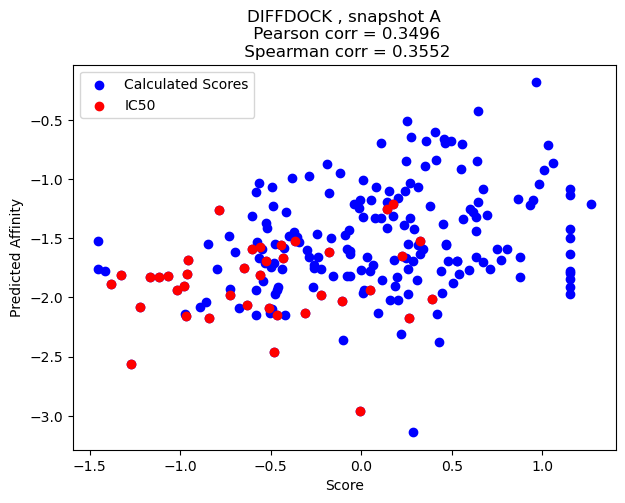

In [5]:
rank_correlation(f'data/A/docked_diffdock_poses_A_{data_suffix}.sdf', common_ID)

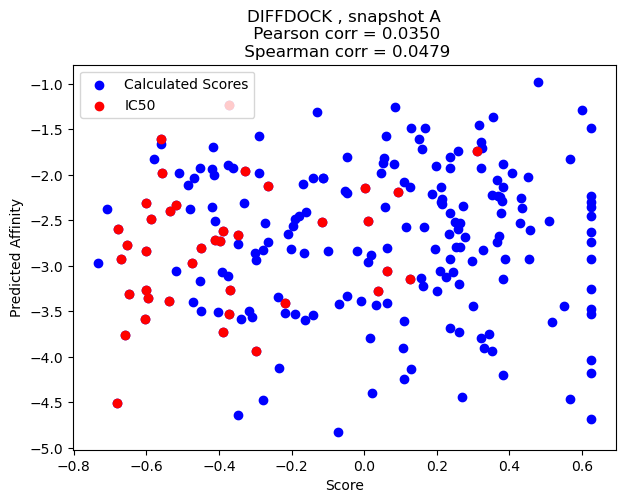

In [6]:
rank_correlation('data/A/docked_diffdock_preconditioned_poses_A_new_ecf_score_final.sdf', common_ID)

rescoring directory is already created.
DIFFDOCK is now rescored ... 



RF-SCORE-VS Running ... 





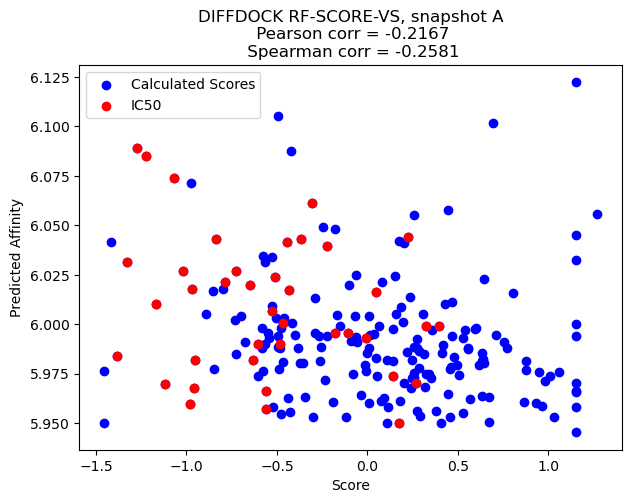

VINARDO Running ... 





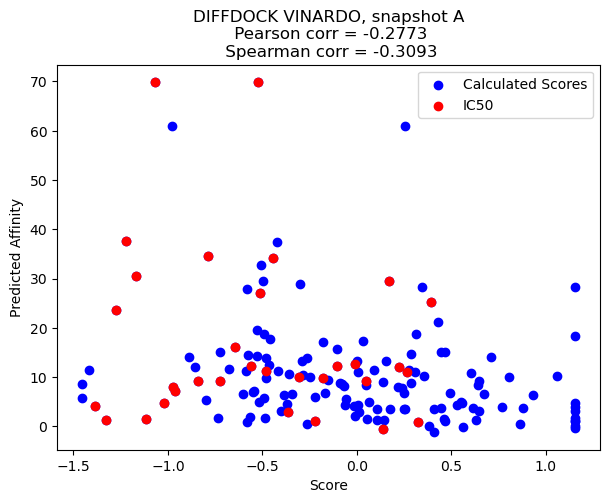

AD4 Running ... 





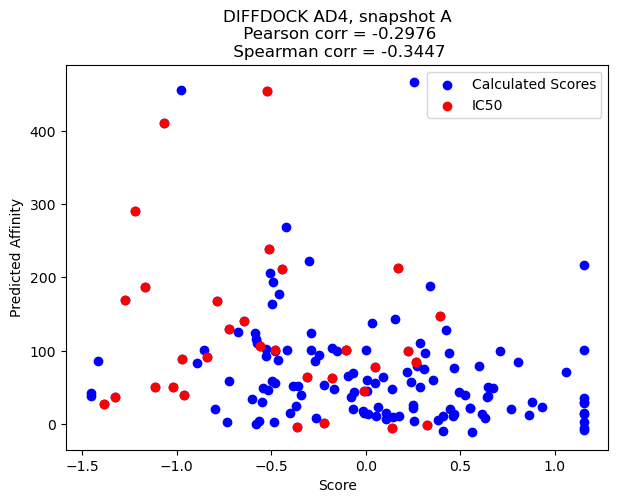

ODDT Running ... 





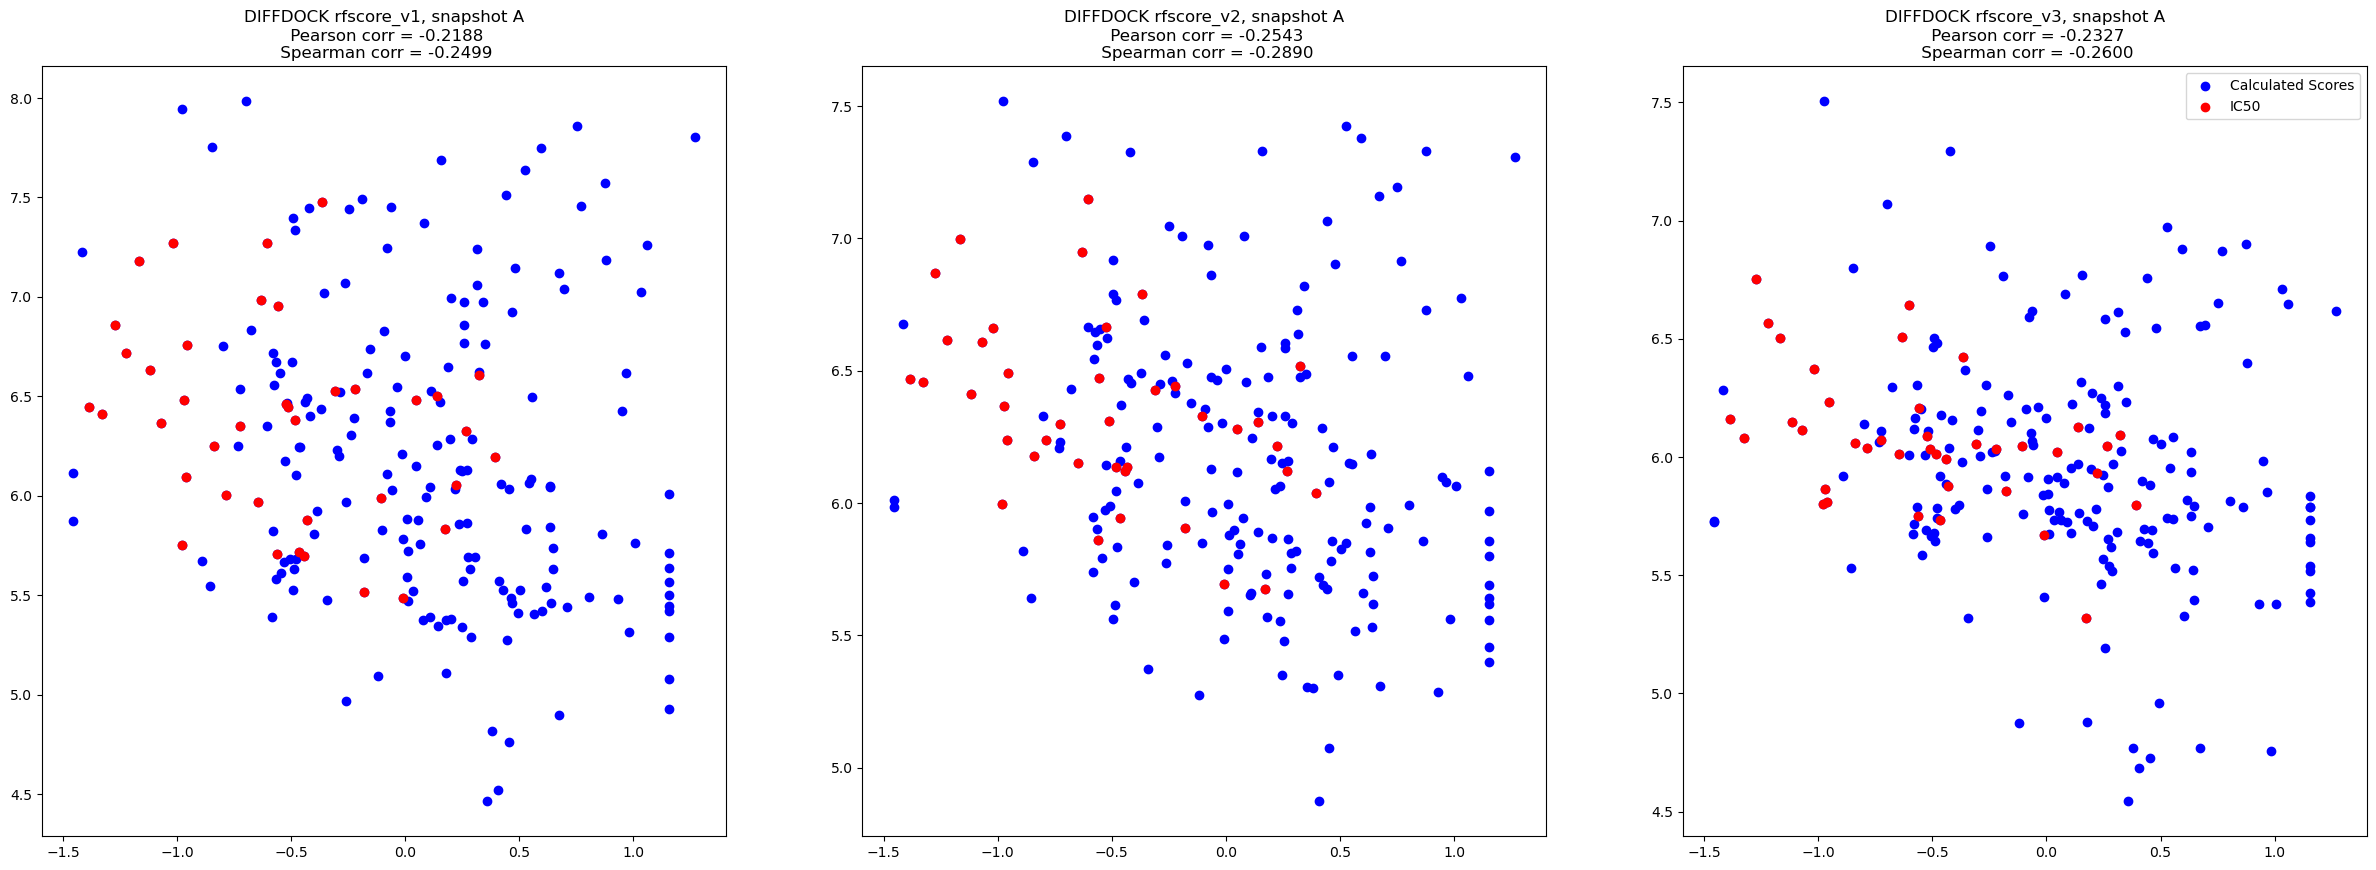

DIFFDOCK_PRECONDITIONED is now rescored ... 



RF-SCORE-VS Running ... 





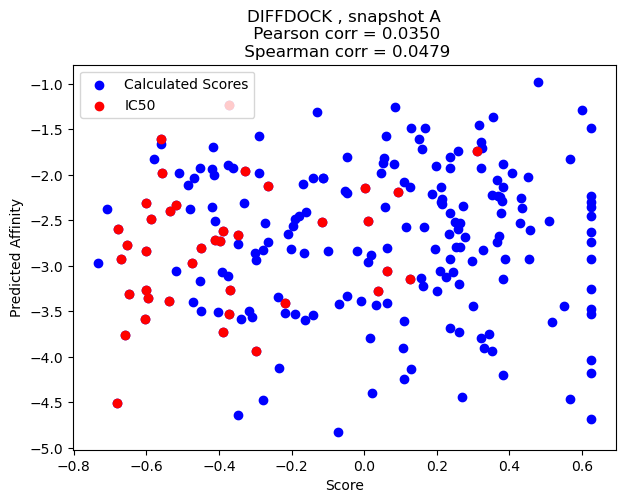

VINARDO Running ... 





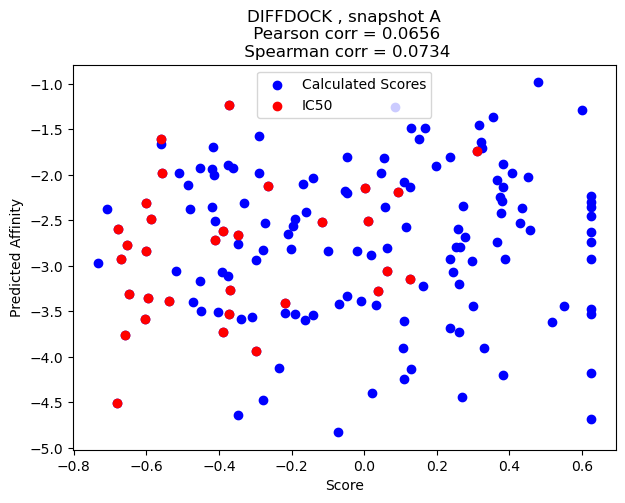

AD4 Running ... 





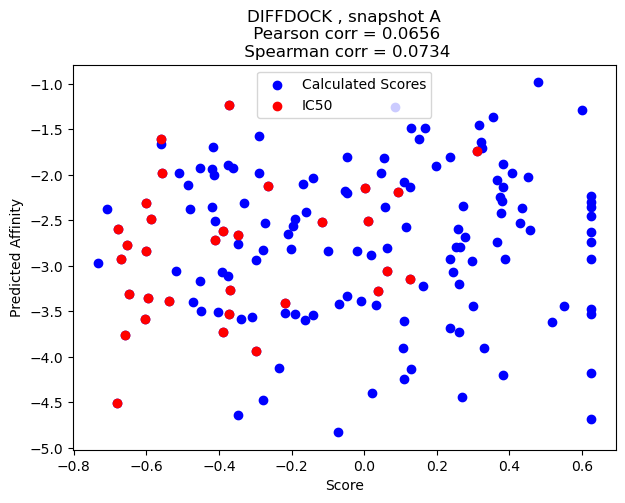

ODDT Running ... 





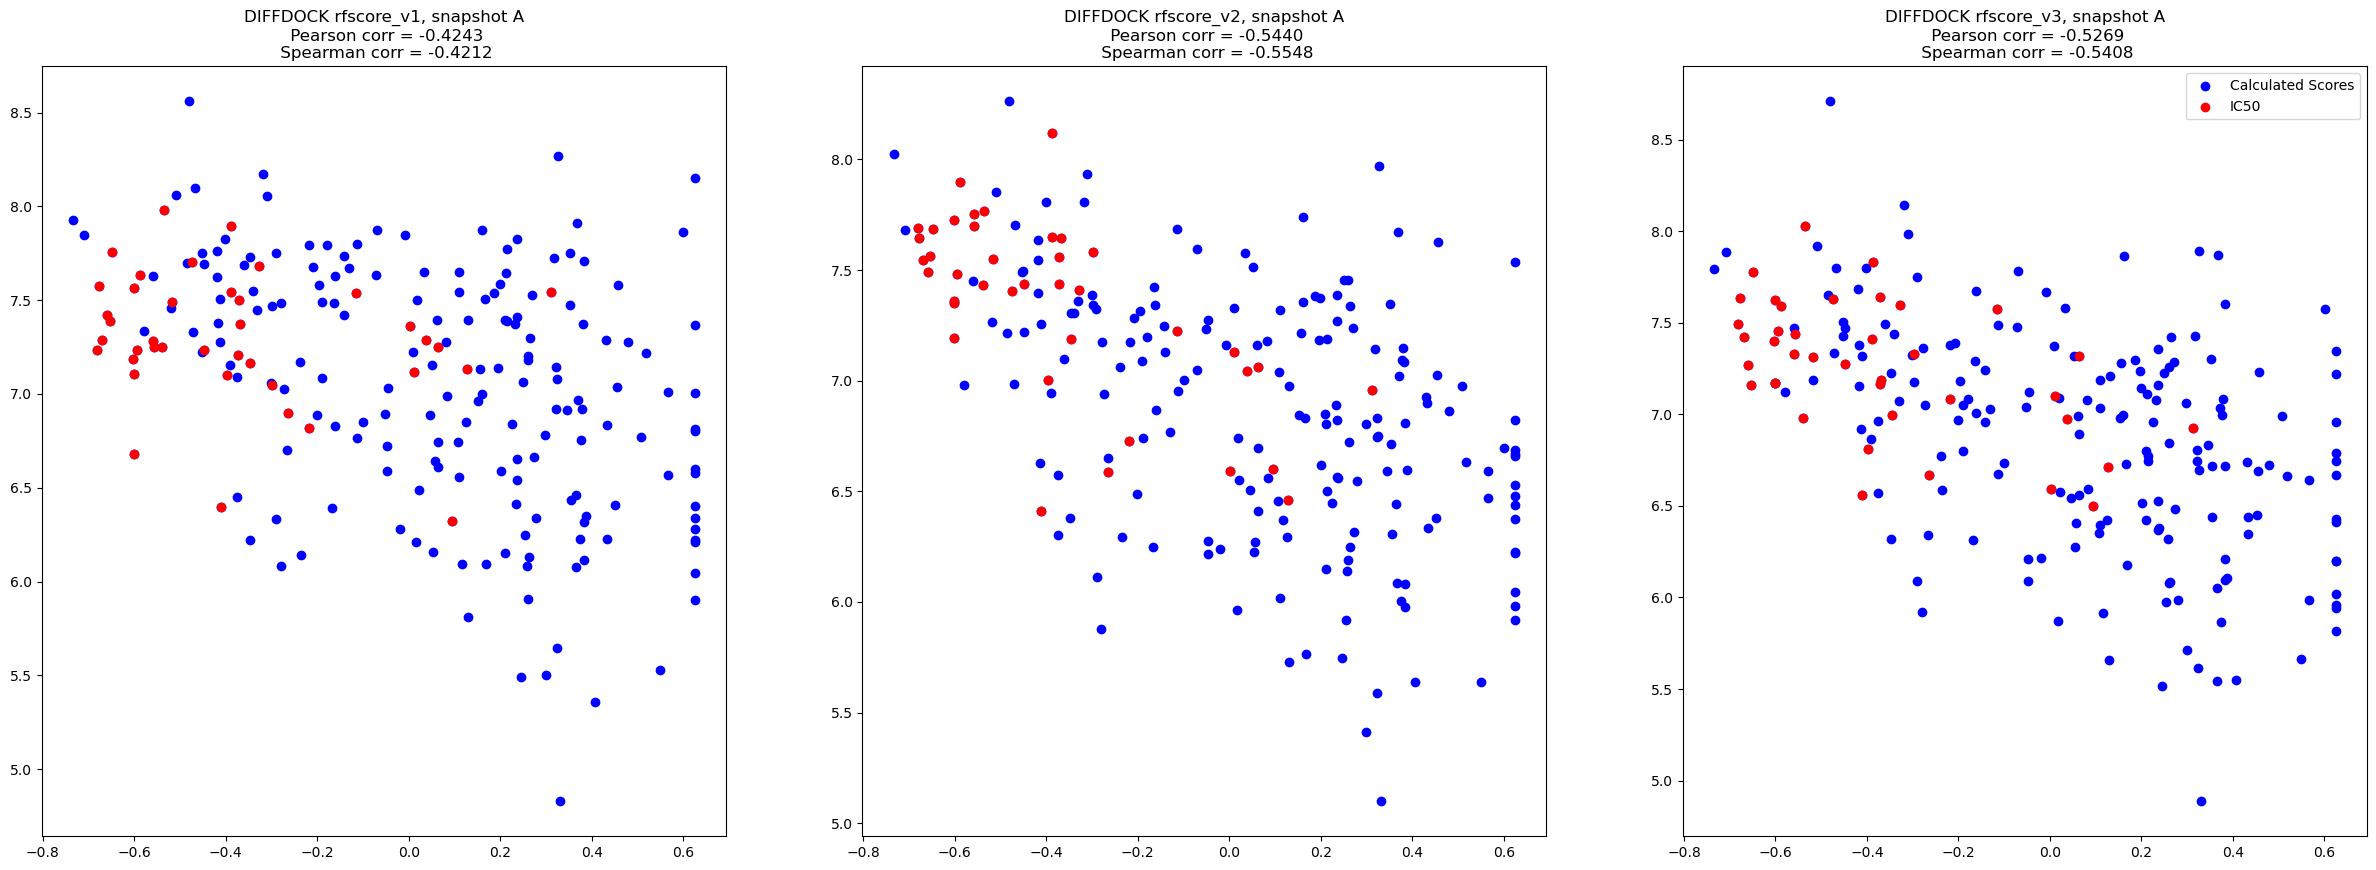

In [7]:
rescoring_functions(['diffdock', 'diffdock_preconditioned'], [ 'rf-score-vs','vinardo', 'ad4', 'oddt'], snapshot_ID, data_suffix, common_ID)

#### DiffDock results are read and evaluated.

In [5]:
def read_diffdock_output(df, results_path):
    '''''
    Read Rank 1 of every docked molecule using DiffDock and write a SDF file with ID, confidence score and Predicted structure

    @Param :

    df : true df data that has score and HIPS code as columns
    results_path : Path of diffdock results

    @Return:
    Write a SDF file with ID, confidence score and Predicted structure
    '''''

    ids = []
    confidence_score = []
    mols = []
    print(os.listdir(results_path))
    for id in os.listdir(results_path):

        for file in os.listdir(results_path / id):

                        if file.startswith('rank1_confidence'):


                            supplier = Chem.SDMolSupplier(
                               str( results_path / id /'rank1.sdf'))
                            if supplier[0] is None:
                                continue
                            mols.append(supplier[0])

                            match = re.search(r"[-+]?\d+(\.\d+)", file)
                            if match:
                                number = match.group(0)
                                confidence_score.append(float(number))
                                ids.append(id)


    diffdock_df = pd.DataFrame({'HIPS code': ids,
                                'confidence_score': confidence_score,
                                'Molecules': mols})

    # merged_df = pd.merge(diffdock_df, df, on='HIPS code', how='inner')[
    #     ['Molecules', 'HIPS code', 'score', 'confidence_score']]
    # merged_df.rename(columns={'HIPS code': 'ID'}, inplace=True)
    
    PandasTools.WriteSDF(
        diffdock_df,
        f'data/A/docked_diffdock_poses_A_preconditioned_rotation_new_ecf_score.sdf',
        idName='HIPS code',
        molColName='Molecules',
        properties=diffdock_df.columns)

read_diffdock_output(df_scores, DATA / 'ecft_data')

['HIPS470_-0.559239', 'HIPS7124_0.061089', 'HIPS6415_-0.114117', 'HIPS6795_-0.047354', 'HIPS5024_0.125184', 'HIPS352_0.130171', 'HIPS6862_0.279055', 'HIPS6296_0.297627', 'HIPS6920_-0.517375', 'HIPS6819_0.451714', 'HIPS5910_0.263325', 'HIPS365_-0.190128', 'HIPS6092_-0.279919', 'HIPS7049_0.236239', 'HIPS6989_-0.680817', 'HIPS6246_-0.051648', 'HIPS6978_0.624666', 'HIPS7001_-0.600806', 'HIPS6134_-0.388179', 'HIPS6997_0.264056', 'HIPS414_-0.141339', 'HIPS5969_-0.272997', 'HIPS407_-0.208611', 'HIPS408_-0.448046', 'HIPS7013_0.232594', 'HIPS6706_0.127161', 'HIPS611_-0.509564', 'HIPS5920_0.353184', 'HIPS5239_0.057063', 'HIPS6457_-0.161331', 'HIPS7069_0.196079', 'HIPS643_0.354816', 'HIPS6037_0.116492', 'HIPS380_-0.411794', 'HIPS6705_0.32468', 'HIPS529_-0.346488', 'HIPS6983_0.37667', 'HIPS6566_-0.410972', 'HIPS6249_0.094298', 'HIPS5165_0.273149', 'HIPS7070_0.159937', 'HIPS5921_-0.179491', 'HIPS431_-0.401459', 'HIPS5963_0.382978', 'HIPS356_0.018857', 'HIPS7126_-0.318021', 'HIPS6794_-0.047094', 'HI

In [ ]:
# sdf = PandasTools.LoadSDF('data/A/docked_seesar_pose_A_score_10pose_cleaned.sdf')
# def convert_id(id_string):
#     parts = id_string.split()[2].split('_')
#     return 'HIPS' + parts[0]

# # sdf['pose'] = sdf['ID'].apply(lambda x: x[-2:])
# sdf['HIPS code'] = sdf['ID'].apply(convert_id)
# # sdf.drop_duplicates(subset=['ID'], inplace=True)
# merged_df = sdf.merge(df_scores, on='HIPS code', how='inner')[['HIPS code', 'pose', 'BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM]', 'ROMol_x', 'ROMol_y', 'score']]

# display(merged_df.head())
# PandasTools.WriteSDF(merged_df, 'data/A/docked_seesar_pose_A_score_10pose_merged.sdf', molColName='ROMol_x', properties=['HIPS code', 'pose','score', 'BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM]'])